In [1]:
# -*- coding: utf-8 -*-
#  File: HW1_sklearn.ipynb
#  Project: 'OTUS Homework #1'
#  Created by Gennady Matveev (gm@og.ly) on 25-12-2021.

### Google colab specific part


Typical runtime on colab with initial 'toy' GridSearchCV parameters is around 12 minutes (so far) and will increase linearly should you decide to play with them.


Please turn on GPU support in notebook settings and install packages below

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
!pip install catboost pandas-profiling==3.0.0

     |████████████████████████████████| 76.3 MB 58 kB/s 
     |████████████████████████████████| 248 kB 35.7 MB/s 
     |████████████████████████████████| 675 kB 35.3 MB/s 
     |████████████████████████████████| 62 kB 725 kB/s 
     |████████████████████████████████| 102 kB 40.8 MB/s 
     |████████████████████████████████| 10.9 MB 23.7 MB/s 
     |████████████████████████████████| 3.1 MB 23.9 MB/s 
     |████████████████████████████████| 596 kB 39.6 MB/s 
     |████████████████████████████████| 812 kB 34.3 MB/s 
     |████████████████████████████████| 38.1 MB 11.4 MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=c81f088a806bf96c47c6b431e39a5ba987603f29c74f8900a87e345a0187efd6
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295207 sha256=11c52fd55d88e3991d3743dd941a334bd4f436f649ccfaa402503058bba0a7f4


TODO: edit requirements

# **$Homework 1$**  


Goals:   
- Compare four gradient boosting algorithms: sklearn GBT, XGBoost, CatBoost, LightGBM
- Implement EDA, preprocessing, and feature engineering
- Tune hyperparameters

Means:  
- All meaningful programming will be done in scikit-learn
- Feature engineering and selection is done with autofeat library

Dataset:
- Telco Customer Churn https://github.com/pmservice/wml-sample-models/raw/master/spark/customer-satisfaction-prediction/data/WA_Fn%20UseC_%20Telco%20Customer%20Churn.csv

Abbreviations:
- EDA: exploratory data analysis
- FE: feature engineering
- H/P: hyperparameters

### Import libraries and setup notebook

In [3]:
import pandas as pd
import numpy as np
# ******************* sklearn ********************
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
# from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import make_scorer, confusion_matrix, \
    plot_confusion_matrix, classification_report, \
    roc_auc_score, f1_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
# ******************* sklearn ********************
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from skopt.space.space import Real, Integer
from scipy.io import arff
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
import warnings
import sys
# sys.path.append('/content/drive/MyDrive/OTUS_HW1/src') #<--- COLAB
# sys.path.append('../src/')
# from utilities import *


#### Miscellaneius settings 

In [4]:
%matplotlib inline
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize']=(8,5)
sns.set(rc={'figure.figsize': (8,5)})
warnings.filterwarnings("ignore")
pd.options.display.precision = 4
random_state = 17
njobs = 6

#### Parameters of GridSearchCV

In [5]:
gridsize_n_estimators = 4
maxdepth = [2, 3]
gridsize_learning_rate = 4

#### Parameters of DFS and RFECV

In [6]:
# n_features_dfs = 128
# n_features_rfecv = 64

### Load data

In [7]:
url = 'https://github.com/pmservice/wml-sample-models/raw/master/spark/customer-satisfaction-prediction/data/WA_Fn%20UseC_%20Telco%20Customer%20Churn.csv'
df = pd.read_csv(url, index_col=0, encoding='utf8')
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Dataset-specific preprocessing - convert target to 0/1 and TotalCharges to float

In [8]:
df["Churn"] = df["Churn"].map(lambda y: 1 if y == 'Yes' else 0)
df["SeniorCitizen"] = df["SeniorCitizen"].map(
    lambda y: "Yes" if y == 0 else "No")
df.drop(index=df.index[df["TotalCharges"].str.len() < 2], inplace=True)
df["TotalCharges"] = df["TotalCharges"].astype("float")

####  Split target from features and create train/test split

In [9]:
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

### EDA

#### Basic dataset information

In [10]:
df.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,Yes,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
5575-GNVDE,Male,Yes,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
3668-QPYBK,Male,Yes,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   object 
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null 

In [12]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7032.0,32.4218,24.5453,1.00,9.0000,29.000,55.0000,72.00
MonthlyCharges,7032.0,64.7982,30.0860,18.25,35.5875,70.350,89.8625,118.75
TotalCharges,7032.0,2283.3004,2266.7714,18.80,401.4500,1397.475,3794.7375,8684.80


#### Target values distribution

Target distribution by classes:


0    73.4 %
1    26.6 %
Name: Churn, dtype: object

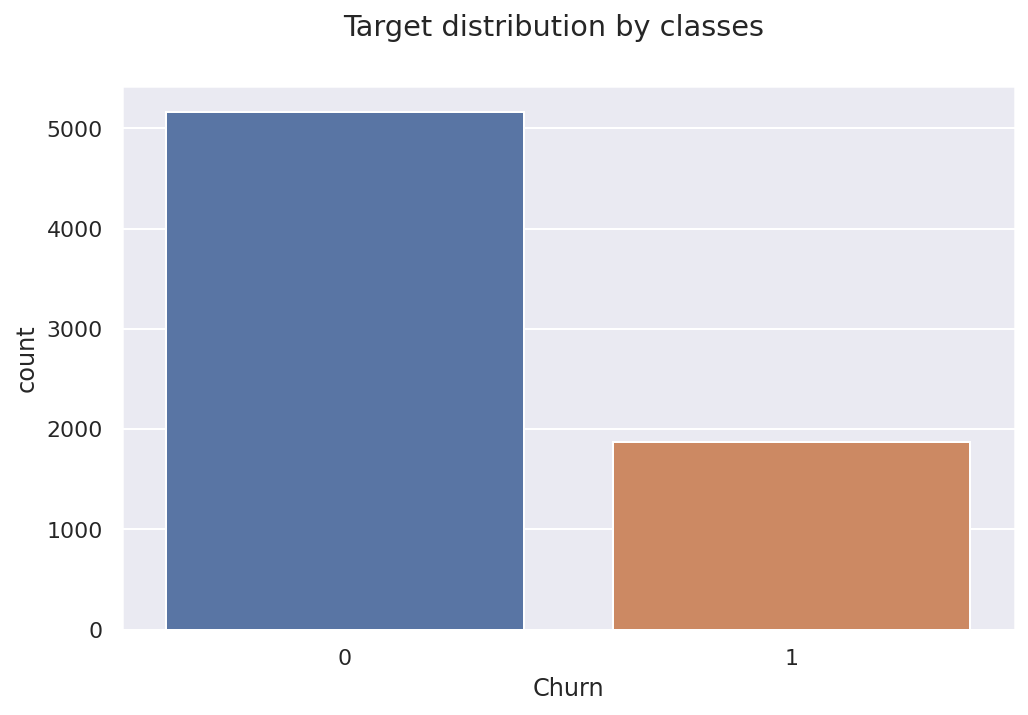

In [13]:
sns.countplot(df['Churn'], data=df)
plt.suptitle('Target distribution by classes')

print(f'Target distribution by classes:')
df["Churn"].value_counts(
    normalize=True).apply(lambda x: f'{x*100:.1f} %')

#### SeniorCitizen, TotalCharges and tenure seem to be important features

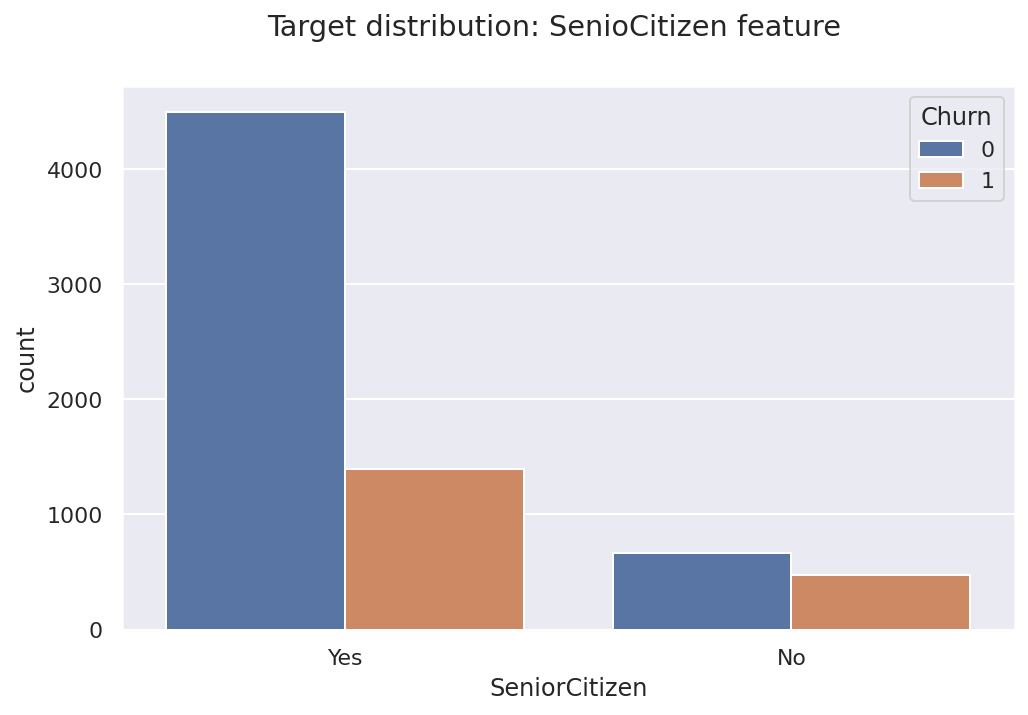

In [14]:
sns.countplot(x=df['SeniorCitizen'], hue=df['Churn'], data=df)
plt.suptitle('Target distribution: SenioCitizen feature')
plt.show()

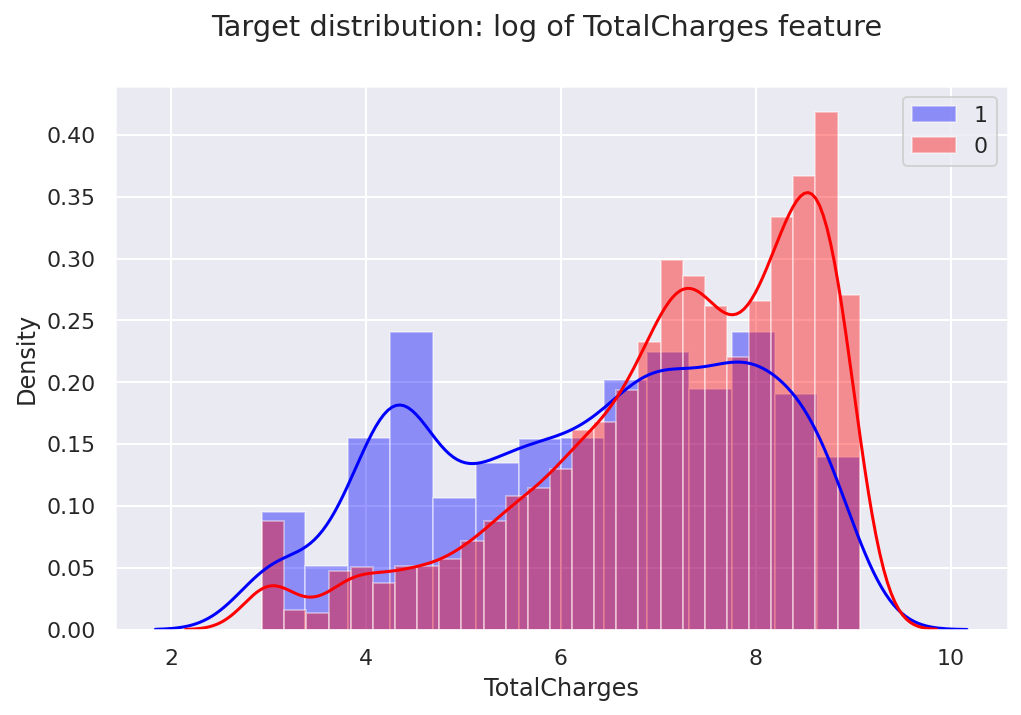

In [15]:
sns.distplot(np.log(df[df["Churn"] == 1]['TotalCharges']),
             color='Blue', label="1")
sns.distplot(np.log(df[df["Churn"] == 0]['TotalCharges']),
             color='Red', label="0")
plt.suptitle('Target distribution: log of TotalCharges feature')
plt.legend()
plt.show()

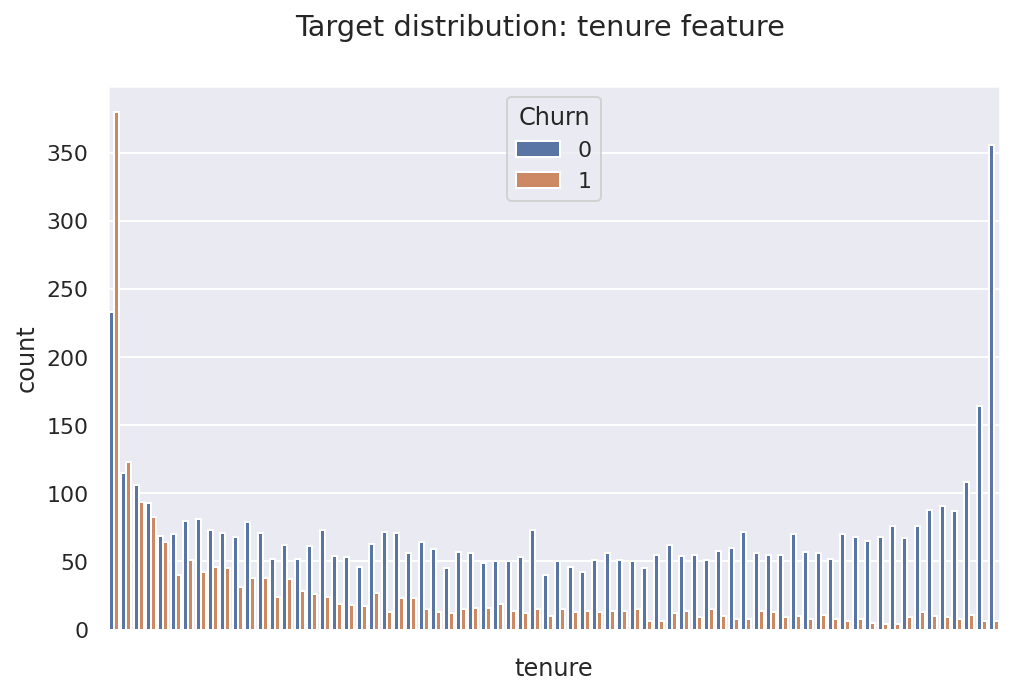

In [16]:
g = sns.countplot(x=np.log(df['tenure']), hue=df['Churn'], data=df)
g.set(xticklabels=[])
plt.suptitle('Target distribution: tenure feature')
plt.show()

#### Run profile report on the dataset

In [17]:
# df.profile_report()

Observations:  
- Dataset now has no missing values
- 
- 

### Pipeline

#### Preprocessing - split  features into numerical and categorical

In [18]:
numerical_columns = df.select_dtypes(
    include=["int", "float"]).columns.to_list()
numerical_features = numerical_columns[:-1]

# All categorical features
categorical_features = df.select_dtypes(
    exclude=["int", "float"]).columns.to_list()

all_features = categorical_features + numerical_features

In [19]:
# atom.plot_scatter_matrix(figsize=(10,10))

#### Define metrics

In [20]:
scoring = {'roc_auc': make_scorer(roc_auc_score),
           'f1': 'f1_score'}

#### Define preprocessing steps of pipeline

In [21]:
def log_transform(x):
    return np.log1p(x + 1)


log_transformer = FunctionTransformer(log_transform)

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='mean')),
    ("log_trsf", log_transformer)])
#     ("scaler", StandardScaler())
#     ("feature_selector", SelectKBest(score_func=f_classif, k=10))])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

data_transformer = ColumnTransformer(transformers=[
    # < -- NB, include target
    ("numerical", numerical_transformer, numerical_features),
    ("categorical", categorical_transformer, categorical_features)])

preprocessor = Pipeline(steps=[("data_transformer", data_transformer)])

#### Define a function to run a pipeline on the dataset

TODO: Collect all results into dataframe and print it.

In [22]:
#
def run_pipe(estimators, grid_search=True):

    models = []

    fig, axes = plt.subplots(
        1, len(estimators), squeeze=False, sharey=True, figsize=(12, 4)) #layout="tight",
    for i, estimator in enumerate(estimators):

        pipeline = Pipeline(steps=[
            ("Preprocessor", preprocessor),
            (estimator[0], estimator[1]),
        ])
        if grid_search:
            param_grid = {
                estimator[0]+"__n_estimators": np.linspace(10, 485, num=gridsize_n_estimators).astype("int"),
                estimator[0]+"__max_depth": maxdepth,
                # [0.01,0.02,0.03,0.04,0.05]
                estimator[0]+"__learning_rate": np.linspace(0.01, 0.1, num=gridsize_learning_rate)
            }

            mod = GridSearchCV(
                pipeline, param_grid, n_jobs=njobs, cv=5, verbose=False)
            grid_size = gridsize_n_estimators*len(maxdepth)*gridsize_learning_rate
            print(f"\n\n{estimator[0]} grid search space: {grid_size} points")
        else:
            mod = pipeline

    # Fit the pipeline
        models.append(mod.fit(X_train, y_train))
        print(
            f"\n========================= {estimator[0]} =========================\n")
        
        y_pred = models[i].predict(X_test)
        print(classification_report(y_test, y_pred))

        roc_auc = roc_auc_score(y_test, models[i].predict_proba(X_test)[:, 1])
        f1 = f1_score(y_test, models[i].predict(X_test))
        print(f"ROC_AUC: {roc_auc:.4f},  F1: {f1:.4f}")
    # sklearn.metrics.ConfusionMatrixDisplay.from_predictions or
    # sklearn.metrics.ConfusionMatrixDisplay.from_estimator
        axs = axes.ravel()
        ConfusionMatrixDisplay.from_predictions(
            y_test, y_pred, colorbar=False, ax=axs[i])
        axs[i].set_title(estimator[0])

    plt.suptitle("Confusion matrices")
    plt.show()

    return models

#### Setup Decision Tree classifier as a baseline model and check its performance


========================= Decision Tree =========================

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1291
           1       0.49      0.53      0.51       467

    accuracy                           0.73      1758
   macro avg       0.66      0.66      0.66      1758
weighted avg       0.73      0.73      0.73      1758

ROC_AUC: 0.6672,  F1: 0.5082


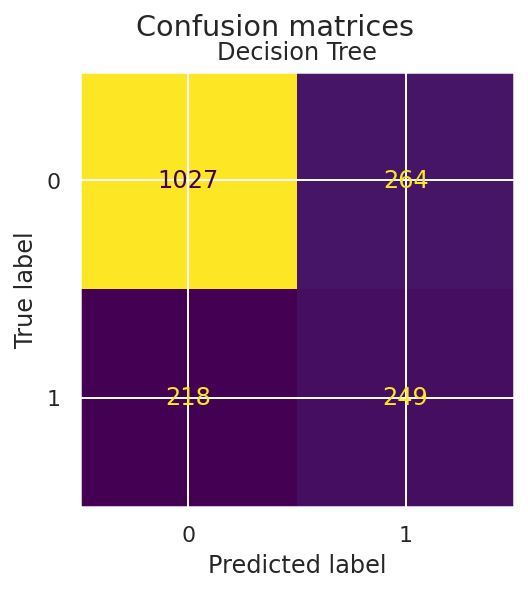

In [23]:
base_estimator = DecisionTreeClassifier(random_state=random_state)
est = [("Decision Tree", DecisionTreeClassifier(random_state=random_state))]

_ = run_pipe(estimators=est, grid_search=False)

#### Run the pipeline for each gardient boosting estimator with default H/Ps


========================= GBM =========================

              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1291
           1       0.69      0.53      0.60       467

    accuracy                           0.81      1758
   macro avg       0.77      0.72      0.74      1758
weighted avg       0.80      0.81      0.80      1758

ROC_AUC: 0.8527,  F1: 0.6022

========================= XGB =========================

              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1291
           1       0.69      0.53      0.60       467

    accuracy                           0.81      1758
   macro avg       0.77      0.72      0.74      1758
weighted avg       0.80      0.81      0.80      1758

ROC_AUC: 0.8513,  F1: 0.5998

========================= CatB =========================

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1291
    

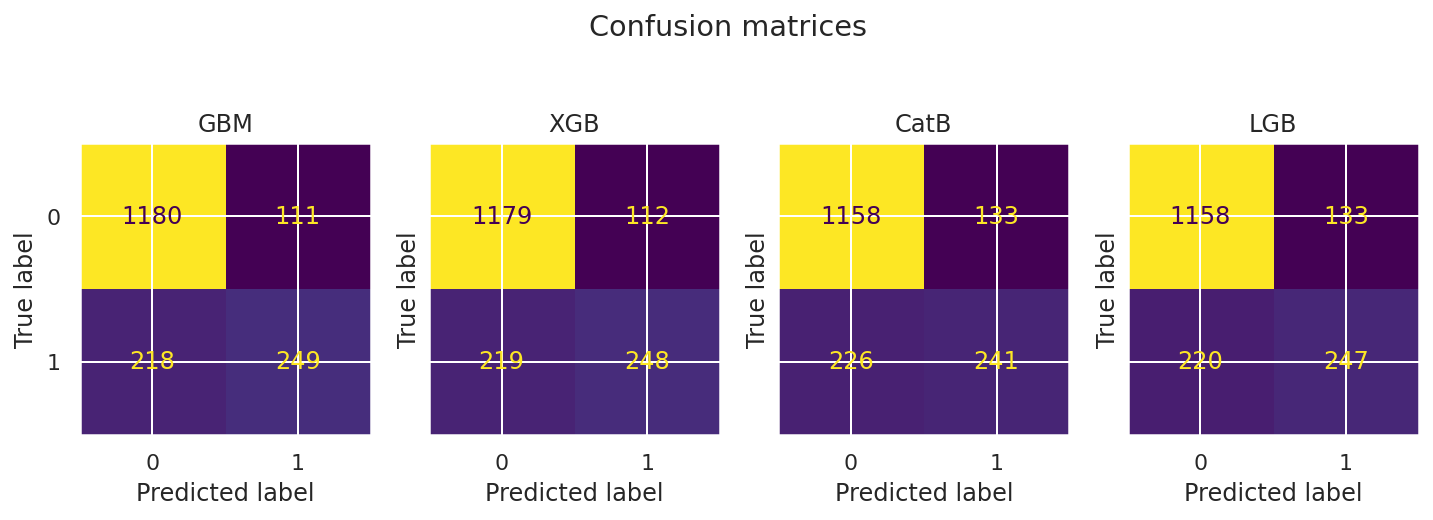

In [24]:
estimators = [
    ("GBM", GradientBoostingClassifier(random_state=random_state)),
    ("XGB", XGBClassifier(tree_method="gpu_hist", eval_metric="logloss",
     use_label_encoder=False, random_state=random_state)),
    ("CatB", CatBoostClassifier(verbose=False, random_state=random_state)),
    ("LGB", LGBMClassifier(force_row_wise=True, verbose=-100, random_state=random_state))]

_ = run_pipe(estimators=estimators, grid_search=False)

#### Tune hyperparameters - GridSearchCV



GBM grid search space: 32 points

========================= GBM =========================

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1291
           1       0.68      0.48      0.56       467

    accuracy                           0.80      1758
   macro avg       0.75      0.70      0.72      1758
weighted avg       0.79      0.80      0.79      1758

ROC_AUC: 0.8515,  F1: 0.5610


XGB grid search space: 32 points

========================= XGB =========================

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1291
           1       0.67      0.52      0.59       467

    accuracy                           0.81      1758
   macro avg       0.76      0.71      0.73      1758
weighted avg       0.80      0.81      0.80      1758

ROC_AUC: 0.8514,  F1: 0.5860


CatB grid search space: 32 points

========================= CatB =========================

       

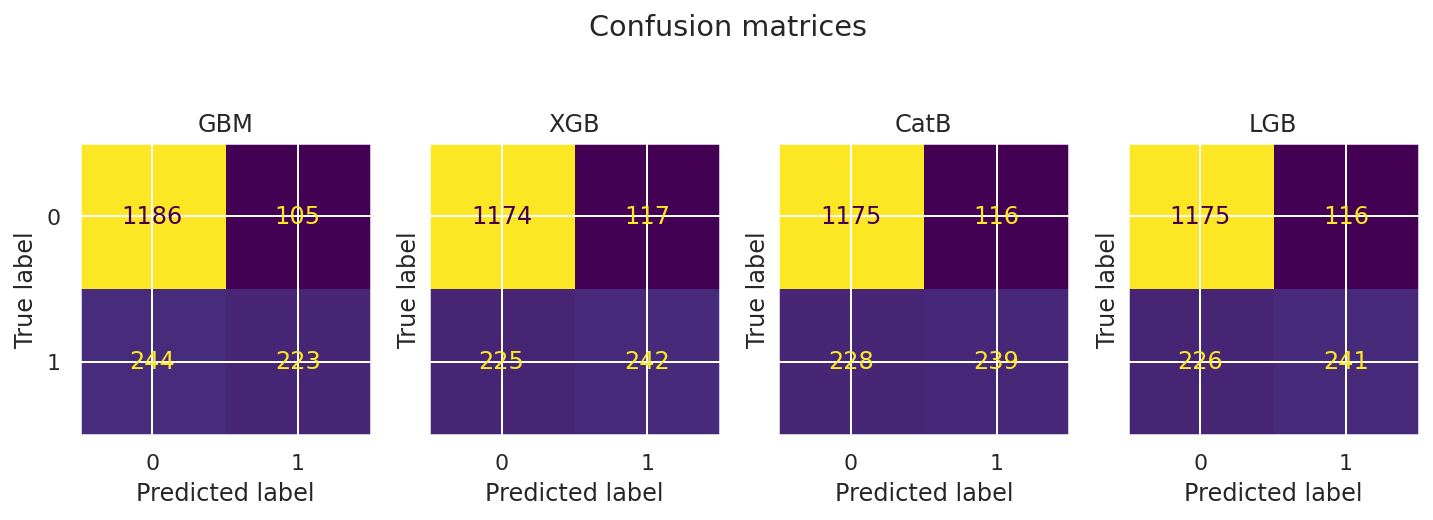

In [25]:
_ = run_pipe(estimators=estimators, grid_search=True)